# 车流量进区域计数-视频预测

同济子豪兄 2023-5-22

## 导入工具包

In [1]:
import time
from tqdm import tqdm

import cv2
import numpy as np

from ultralytics import YOLO

import supervision as sv

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 载入目标检测模型

In [2]:
model = YOLO('yolov8x.pt')

## 载入视频

In [3]:
VIDEO_PATH = 'videos/bridge-short.mp4'

In [4]:
# 获取视频信息
video_info = sv.VideoInfo.from_video_path(VIDEO_PATH)

In [5]:
video_info.resolution_wh

(1920, 1080)

## 提取视频第一帧画面

In [6]:
generator = sv.get_video_frames_generator(VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

In [7]:
frame.shape

(1080, 1920, 3)

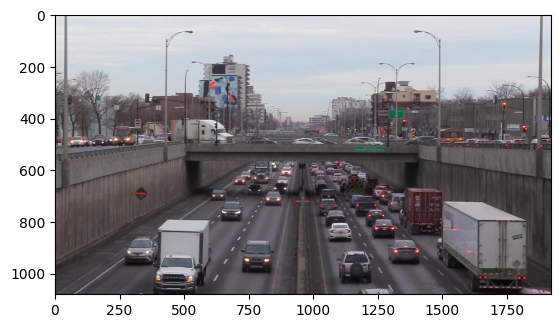

In [8]:
plt.imshow(frame[:,:,::-1])
plt.show()

## 指定多段线区域

In [9]:
polygons = [
    np.array([[600, 680], [927, 680], [851, 950], [42, 950]]),
    np.array([[987, 680], [1350, 680], [1893, 950], [1015, 950]])
]

zones = [sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh) for polygon in polygons]

## 可视化配置

In [10]:
# 配色方案
colors = sv.ColorPalette.default()

In [11]:
# 区域可视化，每个区域配一个 PolygonZoneAnnotator
zone_annotators = [
    sv.PolygonZoneAnnotator(zone=zone, color=colors.by_idx(index), thickness=6, text_thickness=12, text_scale=4)
    for index, zone in enumerate(zones)
]

In [12]:
# 目标检测可视化，每个区域配一个 BoxAnnotator
box_annotators = [
    sv.BoxAnnotator(color=colors.by_idx(index), thickness=2, text_thickness=4, text_scale=2)
    for index in range(len(polygons))
]

## 处理第一帧画面

In [13]:
# YOLOV8 推理预测
results = model(frame, imgsz=1280, verbose=False, show=False, device='cuda:0')[0]

# 用 supervision 解析预测结果
detections = sv.Detections.from_yolov8(results)

# 过滤预测结果，不显示某些类别
# detections = detections[(detections.class_id != 60) & (detections.class_id != 0)]

In [14]:
# detections

In [15]:
# 遍历每个区域对应的所有 Annotator
for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
    
    # 判断目标是否在区域内
    mask = zone.trigger(detections=detections)
    
    # 筛选出在区域内的目标
    detections_filtered = detections[mask]
    
    # 画框
    frame = box_annotator.annotate(scene=frame, detections=detections_filtered, skip_label=True)
    
    # 画区域，并写区域内目标个数
    frame = zone_annotator.annotate(scene=frame)

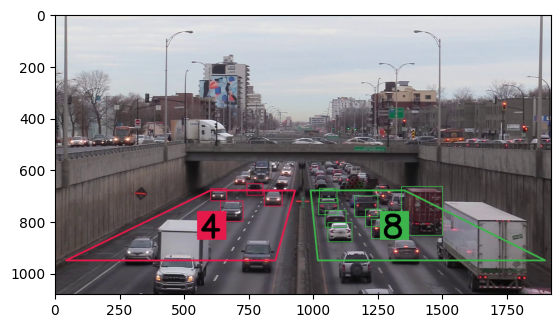

In [16]:
plt.imshow(frame[:,:,::-1])
plt.show()

In [17]:
# mask

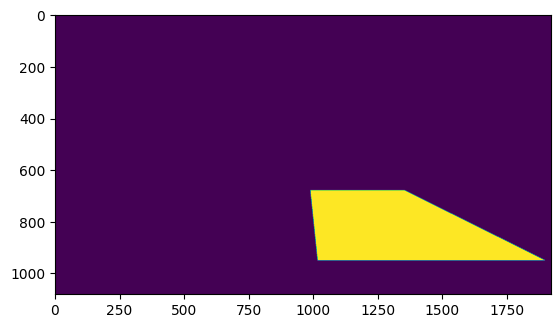

In [18]:
plt.imshow(zone.mask)
plt.show()

In [19]:
zone.current_count

8

## 逐帧处理函数

In [20]:
def process_frame(frame: np.ndarray, i) -> np.ndarray:
    
    '''
    输入 bgr 的 numpy array
    输出 bgr 的 numpy array
    '''
    
    # YOLOV8 推理预测
    results = model(frame, imgsz=1280, verbose=False, show=False, device='cuda:0')[0]

    # 用 supervision 解析预测结果
    detections = sv.Detections.from_yolov8(results)
    
    # 遍历每个区域对应的所有 Annotator
    for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):

        # 判断目标是否在区域内
        mask = zone.trigger(detections=detections)

        # 筛选出在区域内的目标
        detections_filtered = detections[mask]

        # 画框
        frame = box_annotator.annotate(scene=frame, detections=detections_filtered, skip_label=True)

        # 画区域，并写区域内目标个数
        frame = zone_annotator.annotate(scene=frame)
        
    # 更新进度条
    pbar.update(1)

    return frame

## 视频逐帧预测

In [21]:
filehead = VIDEO_PATH.split('/')[-1]
OUT_PATH = "out-" + filehead

In [22]:
with tqdm(total=video_info.total_frames-1) as pbar:
    sv.process_video(source_path=VIDEO_PATH, target_path=OUT_PATH, callback=process_frame)

100%|██████████| 101/101 [00:06<00:00, 14.87it/s]
